# Audio Transcription Tool
This tool attemps to recognize notes played

Really useful resource: https://musicinformationretrieval.com/index.html

In [70]:
# Import standard modules
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

# To use presets, we'll make a dummy import of librosa
# and the display submodule here.
import librosa
import librosa.display


In [58]:
# Load file and create array and sampling rate

filename = 'audio/twinkle.wav'

y, sr = librosa.load(filename, sr = None)


In [59]:
# Estimate tempo of the song
# tempo is the bpm, beat_frames is an array of the frame number for each beat
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
print(tempo)
print(beat_frames)

# Split into frames based on tempo
# Beat times is an array of each beat instance in seconds in song
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

print(beat_times)

120.185319767
[   3   47   90  133  176  219  262  305  348  391  434  477  520  564  607
  650  693  736  779  822  865  908  951  994 1037 1080 1123 1166 1209 1253
 1296 1339 1382 1425 1468 1511 1554 1597 1640 1683 1726 1769 1812 1855 1899
 1942]
[  0.03482993   0.54566893   1.04489796   1.54412698   2.04335601
   2.54258503   3.04181406   3.54104308   4.04027211   4.53950113
   5.03873016   5.53795918   6.03718821   6.54802721   7.04725624
   7.54648526   8.04571429   8.54494331   9.04417234   9.54340136
  10.04263039  10.54185941  11.04108844  11.54031746  12.03954649
  12.53877551  13.03800454  13.53723356  14.03646259  14.54730159
  15.04653061  15.54575964  16.04498866  16.54421769  17.04344671
  17.54267574  18.04190476  18.54113379  19.04036281  19.53959184
  20.03882086  20.53804989  21.03727891  21.53650794  22.04734694
  22.54657596]


In [60]:
# Separate harmonics and percussives into two waveforms
y_harmonic, y_percussive = librosa.effects.hpss(y)
print(y_harmonic)
print(y_percussive)

[ 0.00023482  0.00025893  0.00026327 ...,  0.          0.          0.        ]
[-0.00023482 -0.00025893 -0.00026327 ...,  0.          0.          0.        ]


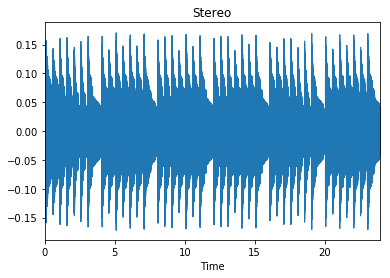

In [61]:
# Plot waveform
librosa.display.waveplot(y, sr=sr)
plt.title('Stereo')
plt.show()

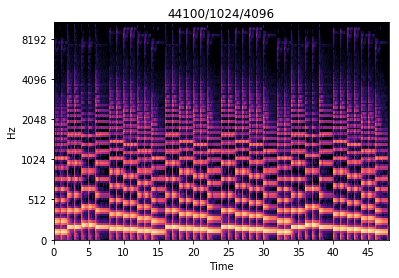

In [62]:
# Generate a Mel spectrogram:

M = librosa.feature.melspectrogram(y=y)

# And plot the spectrogram

librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                         y_axis='mel', x_axis='time')

plt.title('44100/1024/4096')

plt.show()

# Method 1: Autocorrelation

In [63]:
onset_samples = librosa.onset.onset_detect(y,
                                           sr=sr, units='samples', 
                                           hop_length=100, 
                                           backtrack=False,
                                           pre_max=20,
                                           post_max=20,
                                           pre_avg=100,
                                           post_avg=100,
                                           delta=0.2,
                                           wait=0)

print(onset_samples)

onset_boundaries = np.concatenate([[0], onset_samples, [len(y)]])

[   1300   23400   45500   67500   89500  111600  133600  177700  199800
  221900  243900  266000  288000  310100  354100  376200  398200  420300
  442400  464400  486500  530500  552600  574600  596700  618800  640800
  662900  707000  729000  751100  773100  795100  817200  839200  883300
  905400  927500  949500  971600  993600 1015700]


In [64]:
# Helper method to guess pitch
def estimate_pitch(segment, sr, fmin=20.0, fmax=5000.0):
    
    # Compute autocorrelation of input segment.
    r = librosa.autocorrelate(segment)
    
    # Define lower and upper limits for the autocorrelation argmax.
    i_min = sr/fmax
    i_max = sr/fmin
    r[:int(i_min)] = 0
    r[int(i_max):] = 0
    
    # Find the location of the maximum autocorrelation.
    i = r.argmax()
    f0 = float(sr)/i
    return f0

In [65]:
# Generates a pure tone for playback
def generate_sine(f0, sr, n_duration):
    n = np.arange(n_duration)
    return 0.2*np.sin(2*np.pi*f0*n/float(sr))

In [66]:
def estimate_pitch_and_generate_sine(x, onset_samples, i, sr):
    n0 = onset_samples[i]
    n1 = onset_samples[i+1]
    f0 = estimate_pitch(x[n0:n1], sr)
    return generate_sine(f0, sr, n1-n0)

In [67]:
# Use list comprehension to concatenate synthesized segments
y = np.concatenate([
    estimate_pitch_and_generate_sine(y, onset_boundaries, i, sr=sr)
    for i in range(len(onset_boundaries)-1)
])

In [71]:
# Play transcription
ipd.Audio(y, rate=sr)

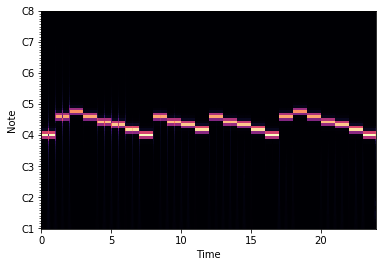

In [73]:
# Plot
cqt = librosa.cqt(y, sr=sr)
librosa.display.specshow(abs(cqt), sr=sr, x_axis='time', y_axis='cqt_note')
plt.show()

# Method 2: Machine Learning